# Notebook to demonstrate plotting of station models

In [21]:
import numpy as np
import numpy.ma as ma
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as ticker
import matplotlib.dates as dates
from mpl_toolkits.axes_grid1 import ImageGrid,make_axes_locatable,host_subplot
#from mpl_toolkits.basemap import Basemap
from datetime import datetime, timedelta
import sys
import os
import pyPIPS.utils as utils
import pyPIPS.thermolib as thermo
import pyPIPS.DSDlib as dsd
#import pyPIPS.disdrometer_module as dis
import pyPIPS.plotmodule as PIPSplot
#import pyPIPS.simulator as sim
import pyPIPS.pips_io as pipsio
import pyPIPS.PIPS as pips
import pyPIPS.parsivel_params as pp
import pyPIPS.parsivel_qc as pqc
import pyPIPS.polarimetric as dualpol
import pyPIPS.timemodule as ptime
# from pyCRMtools.modules import plotmodule as plotmod
from pyCRMtools.modules import utils as CRMutils
# from pyCRMtools.pycaps import arps_read
# from pyCRMtools.pycaps import pycaps_fields
# from pyCRMtools.pycaps import calvars_radar as radar

# Stesonet plotting stuff. Need to add location to the path

sys.path.append('/Users/dawson29/Projects/StickNet_Repo')
from functions import calc_dewpoint,calc_thetae,calc_thetav,C_to_F,calc_mslp,convert_wind, parse_currtime
from functions_plotting import scale_bar, plot_logo

import pandas as pd
import xarray as xr
import glob
import numpy.random as random
from scipy.stats import gamma, uniform
from scipy.special import gamma as gammafunc
from scipy import ndimage
from metpy.plots import StationPlot
from metpy.calc import wind_components
from metpy.cbook import get_test_data
from metpy.plots import StationPlot
from metpy.plots.wx_symbols import current_weather, sky_cover
from metpy.units import units
from metpy.plots import USCOUNTIES
from metpy.plots import  StationPlot
import cartopy.crs as ccrs
import cartopy.feature as cfeature
# from natsort import natsorted
from pprint import pprint
import warnings
warnings.simplefilter('ignore')
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
matplotlib.style.use('seaborn-bright')

# # read in cartopy information    
crs = ccrs.PlateCarree()
# Get data to plot state and province boundaries
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lakes',
        scale='10m',
        facecolor='none')


%config InlineBackend.figure_format='retina'

In [3]:
# date = '052516' # '053122' # '030622' # '061416'
# PIPS_dir = '/Users/dawson29/Dropbox/PIPS_data/2016/{}/netcdf'.format(date)
# PIPS_dir = '/Users/dawson29/Dropbox/Projects/PERiLS/PIPS_data/{}_IN_test/netcdf'.format(date)
PIPS_dir = '/Users/dawson29/Dropbox/Projects/PERiLS/PIPS_data/IOP2_033022/netcdf'
# PIPS_dir = '/Users/dawson29/Dropbox/Teaching/2022/EAPS_591_SSFW/PIPS_data/{}/netcdf'.format(date)
# PIPS_dir = '/depot/dawson29/data/Projects/SPOTTR-2016/{}/obsdata/PIPS/netcdf'.format(date)
# PIPS_dir = '/Users/dawson29/Dropbox/PIPS_data/2016/SPOTTR2016/{}/netcdf'.format(date)
# PIPS_dir = '/Users/dawson29/PIPS_data/2023/031123_mass_test/netcdf'
# PIPS_dir = '/Users/dawson29/Dropbox/PIPS_data/2023/022223_mass_test/netcdf'
# PIPS_dir = '/Users/dawson29/PIPS_data/2023/031623_mass_test/netcdf'
# deployment_name = 'SPOTTR_{}'.format(date)
# deployment_name = '031123_mass_test'
# deployment_name = '022223_mass_test'
# deployment_name = '031623_mass_test'
deployment_name = 'IOP2_033022'
PIPS_names = ['PIPS1A', 'PIPS1B', 'PIPS2A', 'PIPS3B']
parsivel_interval = 10
parsivel_filenames = ['parsivel_combined_{}_{}_{:d}s.nc'.format(deployment_name, PIPS_name, parsivel_interval)
                      for PIPS_name in PIPS_names]
parsivel_filepaths = [os.path.join(PIPS_dir, parsivel_filename) for parsivel_filename in parsivel_filenames]
conv_filenames = ['conventional_raw_{}_{}.nc'.format(deployment_name, PIPS_name) for PIPS_name in PIPS_names]
conv_filepaths = [os.path.join(PIPS_dir, conv_filename) for conv_filename in conv_filenames]
parsivel_ds_read_dict = {}
conv_ds_read_dict = {}
for PIPS_name, parsivel_filepath, conv_filepath in zip(PIPS_names, parsivel_filepaths, conv_filepaths):
    parsivel_ds_read_dict[PIPS_name] = xr.load_dataset(parsivel_filepath)
    conv_ds_read_dict[PIPS_name] = xr.load_dataset(conv_filepath)

In [4]:
for PIPS_name in PIPS_names:
    parsivel_ds = parsivel_ds_read_dict[PIPS_name]
    print(parsivel_ds['time'][0], parsivel_ds['time'][-1])

<xarray.DataArray 'time' ()>
array('2022-03-30T23:49:43.000000000', dtype='datetime64[ns]')
Coordinates:
    time           datetime64[ns] 2022-03-30T23:49:43
    flagged_times  int64 0 <xarray.DataArray 'time' ()>
array('2022-03-31T01:25:23.000000000', dtype='datetime64[ns]')
Coordinates:
    time           datetime64[ns] 2022-03-31T01:25:23
    flagged_times  int64 0
<xarray.DataArray 'time' ()>
array('2022-03-30T23:41:53.000000000', dtype='datetime64[ns]')
Coordinates:
    time           datetime64[ns] 2022-03-30T23:41:53
    flagged_times  int64 0 <xarray.DataArray 'time' ()>
array('2022-03-31T01:33:03.000000000', dtype='datetime64[ns]')
Coordinates:
    time           datetime64[ns] 2022-03-31T01:33:03
    flagged_times  int64 0
<xarray.DataArray 'time' ()>
array('2022-03-30T23:59:03.000000000', dtype='datetime64[ns]')
Coordinates:
    time           datetime64[ns] 2022-03-30T23:59:03
    flagged_times  int64 0 <xarray.DataArray 'time' ()>
array('2022-03-31T01:11:43.000000000', dt

In [6]:
# Restrict to certain time range
# start_time = '2022-05-31T23:00' # '2022-03-07T00:00'
# end_time = '2022-06-01T00:05' # '2022-03-08T00:00'
# start_time = '2022-03-30T23:40'
# end_time = '2022-03-31T01:30'
# start_time = '2023-03-12T00:15'
# end_time = '2023-03-12T14:00'
# start_time = '2023-02-22T16:00'
# end_time = '2023-02-23T01:00'
start_time = '2023-03-16T17:45'
end_time = '2023-03-17T15:05'

if False:
    parsivel_ds_dict = {}
    conv_ds_dict = {}
    for PIPS_name in PIPS_names:
        parsivel_ds_dict[PIPS_name] = parsivel_ds_read_dict[PIPS_name].sel(time=slice(start_time, end_time))
        conv_ds_dict[PIPS_name] = conv_ds_read_dict[PIPS_name].sel(time=slice(start_time, end_time))
else:
    parsivel_ds_dict = parsivel_ds_read_dict
    conv_ds_dict = conv_ds_read_dict

In [37]:
parsivel_ds_dict['PIPS1B']

datetimes = parsivel_ds_dict['PIPS1A']['time'].to_index().to_pydatetime()

print(datetimes)

[datetime.datetime(2022, 3, 30, 23, 49, 43)
 datetime.datetime(2022, 3, 30, 23, 49, 53)
 datetime.datetime(2022, 3, 30, 23, 50, 3)
 datetime.datetime(2022, 3, 30, 23, 50, 13)
 datetime.datetime(2022, 3, 30, 23, 50, 23)
 datetime.datetime(2022, 3, 30, 23, 50, 33)
 datetime.datetime(2022, 3, 30, 23, 50, 43)
 datetime.datetime(2022, 3, 30, 23, 50, 53)
 datetime.datetime(2022, 3, 30, 23, 51, 3)
 datetime.datetime(2022, 3, 30, 23, 51, 13)
 datetime.datetime(2022, 3, 30, 23, 51, 23)
 datetime.datetime(2022, 3, 30, 23, 51, 33)
 datetime.datetime(2022, 3, 30, 23, 51, 43)
 datetime.datetime(2022, 3, 30, 23, 51, 53)
 datetime.datetime(2022, 3, 30, 23, 52, 3)
 datetime.datetime(2022, 3, 30, 23, 52, 13)
 datetime.datetime(2022, 3, 30, 23, 52, 23)
 datetime.datetime(2022, 3, 30, 23, 52, 33)
 datetime.datetime(2022, 3, 30, 23, 52, 43)
 datetime.datetime(2022, 3, 30, 23, 52, 53)
 datetime.datetime(2022, 3, 30, 23, 53, 3)
 datetime.datetime(2022, 3, 30, 23, 53, 13)
 datetime.datetime(2022, 3, 30, 23, 

In [42]:
# Get a particular time to plot
time_to_plot = '2022-03-31T00:15'
parsivel_ds_to_plot_dict = {}

for PIPS_name, parsivel_ds in parsivel_ds_dict.items():
    parsivel_ds_to_plot_dict[PIPS_name] = parsivel_ds.sel(time=time_to_plot, method='nearest')
    
obtime = parsivel_ds_to_plot_dict['PIPS1A']['time'].values
obtime = pd.to_datetime(obtime)
print(obtime)


2022-03-31 00:15:03


In [26]:
T_list = []
Td_list = []
pressure_list = []
u_list = []
v_list = []
lats = []
lons = []
elevs = []
for PIPS_name, parsivel_ds in parsivel_ds_to_plot_dict.items():
    geo_loc_str = parsivel_ds.location
    geo_loc = list(map(np.float, geo_loc_str.strip('()').split(',')))
    lats.append(geo_loc[0])
    lons.append(geo_loc[1])
    elevs.append(geo_loc[2])
    
    T_list.append(parsivel_ds['fasttemp'].values)
    Td_list.append(parsivel_ds['dewpoint'].values)
    pressure_list.append(parsivel_ds['pressure'].values)
    u_list.append(parsivel_ds['uavg'].values)
    v_list.append(parsivel_ds['vavg'].values)
    

T_arr = np.array(T_list)
Td_arr = np.array(Td_list)
pressure_arr = np.array(pressure_list)
u_arr = np.array(u_list)
v_arr = np.array(v_list)
    

In [24]:
### find extent of plot
# exact center of plot
clat = np.amin(lats)+ abs(np.amax(lats) - np.amin(lats))/2
clon = np.amin(lons) + abs(np.amin(lons) - np.amax(lons))/2

# NOTE: change these hardcoded values if you want to change relative domain size
# larger (smaller) numbers = larger (smaller) domain
dlat = 0.75 * abs(np.amax(lats) - np.amin(lats))
dlon = 0.75 * abs(np.amin(lons) - np.amax(lons))


if dlon < .1:
    dlon = .1
if dlat < .1:
    dlat = .1

# find corners using the center and the buffers
north_lat, south_lat = clat+dlat, clat-dlat
west_lon, east_lon = clon-dlon, clon+dlon


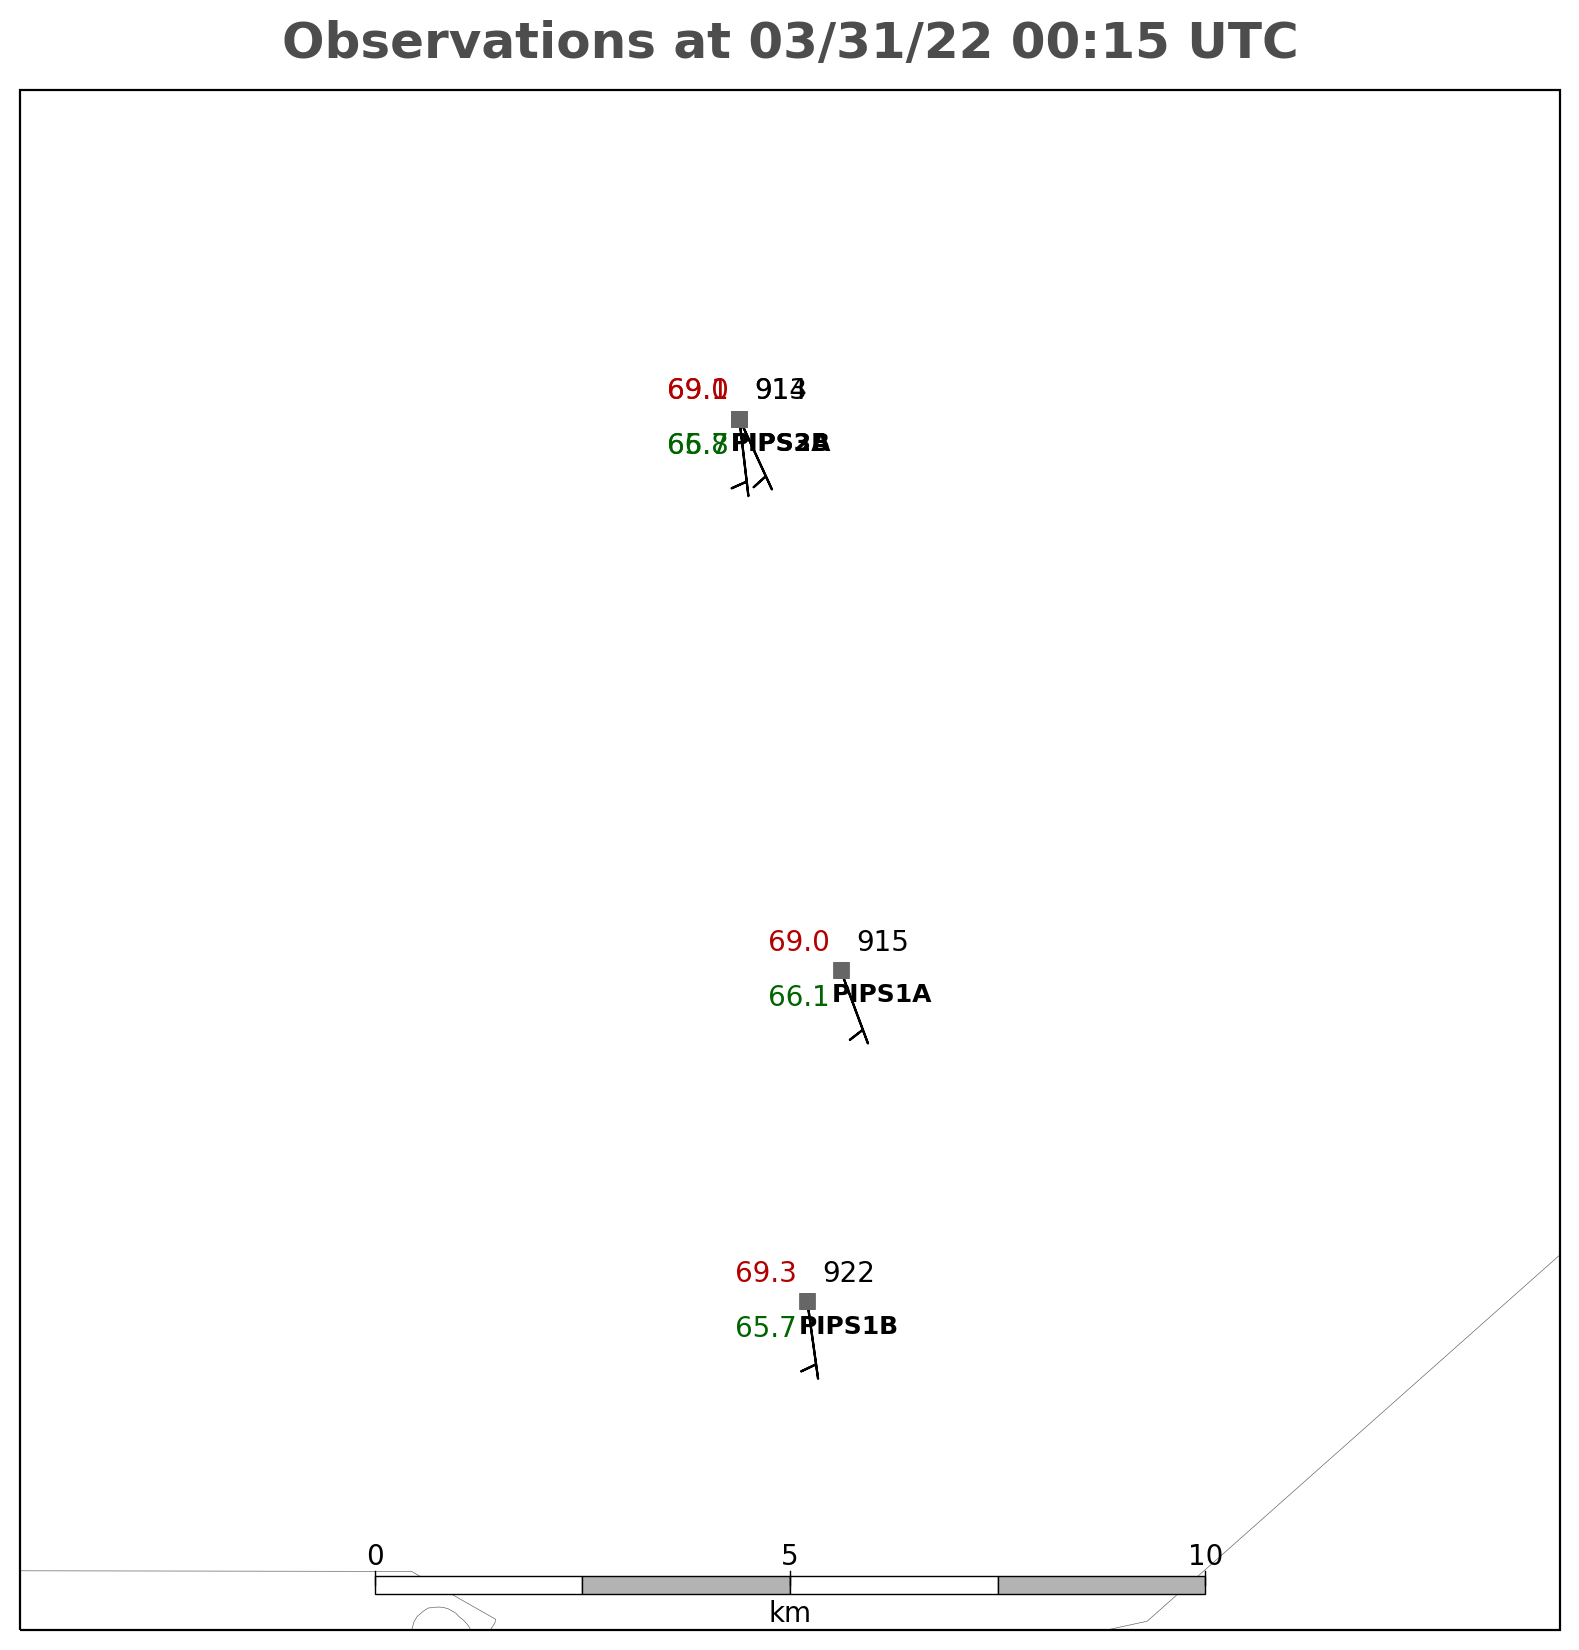

In [43]:
### initialize figure
fig = plt.figure(figsize = [10,10])
ax = fig.add_subplot(1,1,1, projection=crs)
ax.set_extent([west_lon, east_lon, north_lat,south_lat], crs )
ax.add_feature(states_provinces, edgecolor='k', alpha=0.25, linewidth=1)
ax.add_feature(USCOUNTIES.with_scale('20m'), alpha=0.4, linewidth=0.2)


# mark locations of SN
ax.plot(lons,lats,marker='s',color='0.4',markersize=5, linewidth=0)


# use metpy to plot T, Td, MSLP (coded), and the 4-letter identifiers
stationplot = StationPlot(ax, lons, lats, clip_on=True, transform=crs, fontsize=10)
stationplot.plot_parameter((-1.5,1), C_to_F(T_arr), color='#b30000', formatter='0.1f')
stationplot.plot_parameter((-1.5,-1), C_to_F(Td_arr), color='darkgreen', formatter='0.1f')
stationplot.plot_parameter((1.5,1), pressure_arr, formatter=lambda v: format(10 * v, '.0f')[-3:])
stationplot.plot_text((1.5, -.9), PIPS_names, fontsize=9, weight='bold')

# Add wind barbs, dropping bad vals, cuz WS can == -999
# u[abs(u)>60] = 0; v[abs(v)>60] = 0
ax.barbs(lons, lats, u_arr, v_arr, length=7.5, sizes={'emptybarb':.18}, lw=0.8)
                

### title
ax.set_title('Observations at {}'.format(obtime.strftime('%D %H:%M UTC')),
             fontsize=18, y=1.01, weight='bold', color='0.3')

### Plot the TTU logo, have it update location based on shape of base map
# plot_logo(fig, ax)


### Scale Bar
# find appropriate lenght of scale bar
# should be ~ 1/5th the width of the plot
# use 1 deg lon -> 111km approximation (10*10)
center = np.average([ax.get_position().x0, ax.get_position().x1])
#scale_len = np.ceil((abs(np.amin(lons) - np.amax(lons))*10)/4)*10

scale_len = np.ceil((dlon*10)/3.5)*10

if scale_len < 10:
    scale_len = 10
    

scale_bar(fig, ax, length=int(scale_len), location=(center, ax.get_position().y0))
#ax.text(center, 0.01, 'km', ha='center',fontsize=10, transform=ax.transAxes)

# save figure 
# savedir = 'RT_tests' # hard coded real time directory
# nametime = parse_currtime()[1] # note that this may be different from last time on plot
#                              # THATS OKAY... it will make data drops more apparent!
# plt.savefig('{0}/{1}_oban_{2}.png'.format(savedir,name,nametime),dpi=300,bbox_inches = 'tight')
# plt.close()

In [ ]:
## OLD CELLS BELOW ##

In [ ]:
# Try to use OpenStreetMap for images. Taken from 
# https://makersportal.com/blog/2020/4/24/geographic-visualizations-in-python-with-cartopy
import cartopy.io.img_tiles as cimgt
import io
from urllib.request import urlopen, Request
from PIL import Image

In [ ]:
def image_spoof(self, tile): # this function pretends not to be a Python script
    url = self._image_url(tile) # get the url of the street map API
    req = Request(url) # start request
    req.add_header('User-agent','Anaconda 3') # add user agent to request
    fh = urlopen(req) 
    im_data = io.BytesIO(fh.read()) # get image
    fh.close() # close url
    img = Image.open(im_data) # open image with PIL
    img = img.convert(self.desired_tile_form) # set image format
    return img, self.tileextent(tile), 'lower' # reformat for cartopy

In [ ]:
# cimgt.OSM.get_image = image_spoof # reformat web request for street map spoofing
# osm_img = cimgt.OSM() # spoofed, downloaded street map
cimgt.QuadtreeTiles.get_image = image_spoof # reformat web request for street map spoofing
osm_img = cimgt.QuadtreeTiles() # spoofed, downloaded street map

In [ ]:
conv_ds = conv_ds_dict['PIPS1A']

fig = plt.figure(figsize=(12,9)) # open matplotlib figure
ax1 = plt.axes(projection=osm_img.crs) # project using coordinate reference system (CRS) of street map
location = eval(str(conv_ds.location))
ctrlat = location[0]
ctrlon = location[1]
center_pt = [ctrlat, ctrlon]
zoom = 0.1 # for zooming out of center point
extent = [center_pt[1]-(zoom*2.0),center_pt[1]+(zoom*2.0),center_pt[0]-zoom,center_pt[0]+zoom] # adjust to zoom
ax1.set_extent(extent) # set extents
scale = np.ceil(-np.sqrt(2)*np.log(np.divide(zoom,350.0))) # empirical solve for scale based on zoom
scale = (scale<20) and scale or 19 # scale cannot be larger than 19
print(scale)
ax1.add_image(osm_img, int(scale)) # add OSM with zoom specification
# NOTE: zoom specifications should be selected based on extent:
# -- 2     = coarse image, select for worldwide or continental scales
# -- 4-6   = medium coarseness, select for countries and larger states
# -- 6-10  = medium fineness, select for smaller states, regions, and cities
# -- 10-12 = fine image, select for city boundaries and zip codes
# -- 14+   = extremely fine image, select for roads, blocks, buildings
for PIPS_name, conv_ds in conv_ds_dict.items():
    lons = conv_ds['GPS_lon']
    lons = lons.where(conv_ds['GPS_status'] == 'A', drop=True)
    lats = conv_ds['GPS_lat']
    lats = lats.where(conv_ds['GPS_status'] == 'A', drop=True)
    times = conv_ds['time']
    times = times.where(conv_ds['GPS_status'] == 'A', drop=True)
    sc = ax1.scatter(lons, lats, c=times, marker='o', facecolor='none', alpha=1, transform=ccrs.PlateCarree())

fig.colorbar(sc, ax=ax1)
plt.show() # show the plot

In [ ]:
# Old cells below. Check if there is anything important there and then get rid of them

In [ ]:
# Set up map
width_x = 500. # m
width_y = 500. # m

location = eval(str(conv_ds.location))
ctrlat = location[0]
ctrlon = location[1]

trulon = ctrlon
trulat1 = 35.
trulat2 = 45.
projection = ccrs.LambertConformal(ctrlon, ctrlat, false_easting=width_x/2., false_northing=width_y/2.,
                                   standard_parallels=[trulat1, trulat2])

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': projection})

# ax.stock_img()
# Add coastlines and states
ax.coastlines()
land = feature.LAND
ax.add_feature(land) # , edgecolor='face', facecolor=feature.COLORS['land'])
states = feature.STATES
# states = feature.NaturalEarthFeature(category="cultural", scale="50m",
#                                      facecolor="none",
#                                      name="admin_1_states_provinces_shp")
ax.add_feature(states, linewidth=1., edgecolor='k', alpha=0.5)
rivers = feature.RIVERS
ax.add_feature(rivers, linewidth=0.75, edgecolor='b', alpha=0.5)
ax.add_feature(feature.NaturalEarthFeature('cultural', 'roads', '10m'), facecolor='none', edgecolor='b')
# # Add counties if desired. TODO: add back more features here after testing

# # if runname == pc.runname_list[0] and time == time_list[0]:

# print("Reading counties from shapefile")
county_shapefile_location = '/Users/dawson29/Projects/pyCRMtools/data/shapefiles/county/countyp020'
counties = plotmod.read_shapefile(county_shapefile_location)
ax.add_feature(counties, linewidth=0.5, edgecolor='grey', alpha=0.5)

# Add urban areas
# urban_shapefile_location = '/Users/dawson29/Projects/pyCRMtools/data/shapefiles/urban2/tl_2008_us_cbsa'
# urban = plotmod.read_shapefile(urban_shapefile_location)
# ax.add_feature(urban, linewidth=0.5, facecolor='purple', edgecolor='none', alpha=0.25)

# Add more stuff from GADM database (EDIT: doesn't seem to add anything beyond counties)
# gadm_shapefile_location = '/Users/dawson29/Projects/pyCRMtools/data/shapefiles/gadm/gadm36_USA_2'
# gadm_shapes = plotmod.read_shapefile(gadm_shapefile_location)
# ax.add_feature(gadm_shapes, linewidth=0.5, edgecolor='purple', alpha=0.8)

ax.set_xlim(0., width_x)
ax.set_ylim(0., width_y)
# ax.scatter([ctrlon], [ctrlat], color='black', marker='o', facecolor='none', transform=ccrs.PlateCarree())

lons = conv_ds['GPS_lon']
lats = conv_ds['GPS_lat']
ax.scatter(lons, lats, color='black', marker='o', facecolor='none', alpha=0.75, transform=ccrs.PlateCarree())

In [ ]:
print(wind_dir_conv.coords['time'])
print(len(wind_dir_conv.time))
print(len(np.unique(wind_dir_conv.time.data)))
unique_times = np.unique(wind_dir_conv['time'])
print(unique_times)
duplicated = wind_dir_conv.indexes['time'].duplicated()
print(duplicated)
dup_indices = np.where(duplicated)[0]
print(dup_indices)
#duplicated = xr.DataArray(parsivel_ds_read.indexes['time'].duplicated())
duplicated_times = wind_dir_conv['time'].isel(time=dup_indices)
print(duplicated_times)
duplicated_times_only = wind_dir_conv.isel(time=dup_indices)
print(duplicated_times_only)

In [ ]:
time_diff = wind_spd_conv['time'].diff('time').astype(np.float)*1.e-9
print(time_diff)
out_of_order_times = time_diff.where(time_diff < 0, drop=True)['time']
print(out_of_order_times)

In [ ]:
int_indices = range(wind_spd_conv.sizes['time'])
print(wind_spd_conv.coords['time'].values)
int_ind_da = xr.DataArray(int_indices, coords=[('time', wind_spd_conv.coords['time'].values)])
print(int_ind_da)

In [ ]:
print(int_ind_da.sel(time='2017-04-30T20:40:18.000000000'))

In [ ]:
print(wind_spd_conv.isel(time=74415))
print(wind_spd_conv.isel(time=74416))
print(wind_spd_conv.isel(time=74417))
print(wind_spd_conv.isel(time=74418))

In [ ]:
time_diff = parsivel_ds['time'].diff('time').astype(np.float)*1.e-9
print(time_diff)
out_of_order_times = time_diff.where(time_diff < 0, drop=True)['time']
print(out_of_order_times)

In [ ]:
PIPS_dir2 = '/Volumes/scr_fast/Projects/VORTEXSE/obsdata/full_PIPS_dataset_new_test/'
parsivel_filepath2 = os.path.join(PIPS_dir, 'parsivel_combined_FMCW_2017_043017_PIPS2A_60s.nc')
conv_filepath2 = os.path.join(PIPS_dir, 'conventional_raw_FMCW_2017_043017_PIPS2A.nc')
parsivel_ds2 = xr.load_dataset(parsivel_filepath2)
conv_ds2 = xr.load_dataset(conv_filepath2)

In [ ]:
time_diff = parsivel_ds2['time'].diff('time').astype(np.float)*1.e-9
print(time_diff)
out_of_order_times = time_diff.where(time_diff < 0, drop=True)['time']
print(out_of_order_times)